In [1]:
from typing import *
from datetime import datetime, timedelta
from tqdm import tqdm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np

warnings.simplefilter("ignore")

In [2]:
df = pd.read_parquet(r"D:\data\features\features_2025-05-15@RETURN_4S.parquet")
df.head(2)

,currency_pair,volume_imbalance_0.5S,volume_imbalance_1.0S,volume_imbalance_2.0S,volume_imbalance_5.0S,volume_imbalance_10.0S,volume_imbalance_30.0S,volume_imbalance_60.0S,volume_imbalance_120.0S,volume_imbalance_300.0S,...,mle_alpha_powerlaw_60.0S,mle_alpha_powerlaw_120.0S,mle_alpha_powerlaw_300.0S,return_pips,hold_time_ms,start_time,end_time,starting_trade,ending_trade,return_pips_adjusted
0,ADAUSDT,1.0,1.0,1.0,0.178886,0.297637,-0.091779,0.460684,-0.131251,-0.016447,...,1.368993,1.300652,1.289072,-10.048568,5.246,2024-01-01 00:00:00,2024-01-01 00:05:00,2024-01-01 00:04:59.816,2024-01-01 00:05:05.062,-9.577362
1,ADAUSDT,NaN,-1.0,-1.0,-0.999438,-0.981151,-0.856979,0.024031,-0.227971,-0.089989,...,1.350496,1.297855,1.284644,-8.379420,8.970,2024-01-01 00:00:05,2024-01-01 00:05:05,2024-01-01 00:05:04.151,2024-01-01 00:05:13.121,-4.670803


In [3]:
df[["start_time", "end_time", "starting_trade", "ending_trade", "return_pips", "return_pips_adjusted"]]

,start_time,end_time,starting_trade,ending_trade,return_pips,return_pips_adjusted
0,2024-01-01 00:00:00,2024-01-01 00:05:00,2024-01-01 00:04:59.816,2024-01-01 00:05:05.062,-10.048568,-9.577362
1,2024-01-01 00:00:05,2024-01-01 00:05:05,2024-01-01 00:05:04.151,2024-01-01 00:05:13.121,-8.379420,-4.670803
2,2024-01-01 00:00:10,2024-01-01 00:05:10,2024-01-01 00:05:07.937,2024-01-01 00:05:15.259,1.677290,1.145377
3,2024-01-01 00:00:15,2024-01-01 00:05:15,2024-01-01 00:05:14.981,2024-01-01 00:05:20.055,0.000000,0.000000
4,2024-01-01 00:00:20,2024-01-01 00:05:20,2024-01-01 00:05:16.843,2024-01-01 00:05:26.222,-5.031869,-2.682519
...,...,...,...,...,...,...
456997,2024-01-09 23:54:40,2024-01-09 23:59:40,2024-01-09 23:59:39.390,2024-01-09 23:59:45.115,0.426568,0.372549
456998,2024-01-09 23:54:45,2024-01-09 23:59:45,2024-01-09 23:59:44.829,2024-01-09 23:59:50.414,-0.298584,-0.267309
456999,2024-01-09 23:54:50,2024-01-09 23:59:50,2024-01-09 23:59:49.999,2024-01-09 23:59:55.014,0.042656,0.042529
457000,2024-01-09 23:54:55,2024-01-09 23:59:55,2024-01-09 23:59:52.824,2024-01-10 00:00:00.000,-0.127968,-0.089164


In [4]:
desired_offsets: List[timedelta] = [
    timedelta(milliseconds=500),
    timedelta(seconds=1),
    timedelta(seconds=2),
    timedelta(seconds=5),
    timedelta(seconds=10),
    timedelta(seconds=30),
    timedelta(minutes=1),
    timedelta(minutes=2),
    timedelta(minutes=5),
]

def get_seconds_postfix(td: timedelta) -> str:
    return f"{td.total_seconds()}S"

In [5]:
df["cross_section_id"] = df.groupby(["start_time", "end_time"]).ngroup()

In [26]:
volume_imbalance_features = [f"volume_imbalance_{get_seconds_postfix(offset)}" for offset in desired_offsets]
slippage_imbalance_features = [f"slippage_imbalance_{get_seconds_postfix(offset)}" for offset in desired_offsets]
log_return_features = [f"log_return_{get_seconds_postfix(offset)}" for offset in desired_offsets]
mle_alpha_powerlaw_features = [f"mle_alpha_powerlaw_{get_seconds_postfix(offset)}" for offset in desired_offsets]
share_of_long_trades_features = [f"share_of_long_trades_{get_seconds_postfix(offset)}" for offset in desired_offsets]

num_cols: List[str] = (
    volume_imbalance_features + slippage_imbalance_features + 
    log_return_features + mle_alpha_powerlaw_features + share_of_long_trades_features
)

target_col: str = "return_pips_adjusted"
cat_cols: List[str] = ["currency_pair"]
reg_cols: List[str] = num_cols + cat_cols

6it [00:00,  6.21it/s]


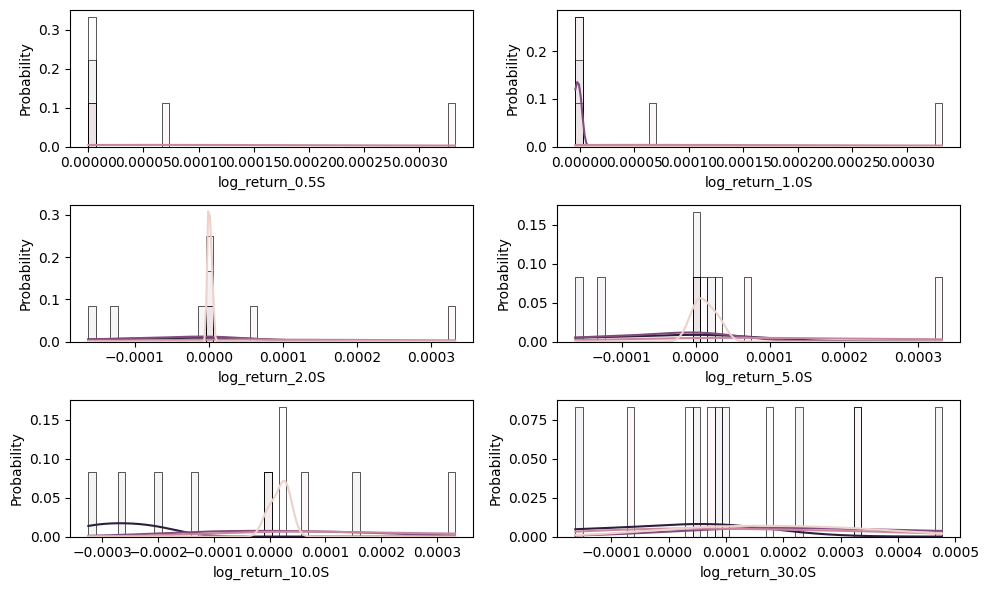

In [27]:
df_plot = df[df["cross_section_id"].isin([0, 10000, 20000, 30000])].copy()
fig, axs = plt.subplots(3, 2, figsize=(10, 6))
axs = axs.flatten()

for ax, col in tqdm(zip(axs, log_return_features)):
    sns.histplot(
        data=df_plot, x=col, hue="cross_section_id", ax=ax, legend=False, alpha=0.05, bins=50, kde=True,
        stat="probability"
    )

plt.tight_layout()

In [9]:
for col in mle_alpha_powerlaw_features:
    df[col] = df[col].replace(np.nan, np.inf)
    df[col] = df[col].clip(1, 2)

In [10]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
volume_imbalance_0.5S,284798.0,-0.008091,-1.0,-1.0,-0.015356,1.0,1.0,0.885182
volume_imbalance_1.0S,358458.0,-0.013355,-1.0,-0.989124,-0.033344,0.982435,1.0,0.856618
volume_imbalance_2.0S,412102.0,-0.012376,-1.0,-0.917414,-0.027002,0.897772,1.0,0.811621
volume_imbalance_5.0S,447123.0,-0.006634,-1.0,-0.740822,-0.011417,0.725872,1.0,0.72371
volume_imbalance_10.0S,455623.0,-0.003386,-1.0,-0.586325,-0.005395,0.579151,1.0,0.638833
volume_imbalance_30.0S,457000.0,-0.004667,-1.0,-0.380414,-0.002981,0.369487,1.0,0.486631
volume_imbalance_60.0S,457002.0,-0.004138,-1.0,-0.281967,-0.002128,0.275106,1.0,0.392463
volume_imbalance_120.0S,457002.0,-0.004037,-0.969169,-0.21316,-0.002317,0.207269,0.969738,0.310577
volume_imbalance_300.0S,457002.0,-0.004328,-0.862929,-0.151027,-0.002266,0.144625,0.882697,0.223458
slippage_imbalance_0.5S,98700.0,-0.009873,-1.0,-1.0,-0.022222,1.0,1.0,0.905589


In [11]:
df["currency_id"] = df["currency_pair"].astype("category").cat.codes

In [12]:
from sklearn.ensemble import RandomForestRegressor
from dataclasses import dataclass
from typing import *


@dataclass
class FeatureSet:
    regressors: List[str]
    target: str
    categorical: Optional[List[str]] = None


# initialize our feature set, that will be used throughtout the notebook
reg_features: FeatureSet = FeatureSet(regressors=num_cols + ["currency_id"], target=target_col)

In [13]:
# train, val, test split
t0: datetime = datetime(2024, 1, 7)
t1: datetime = datetime(2024, 1, 8)

df_train, df_val, df_test = (
    df[df["end_time"] < t0].copy(),
    df[df["end_time"].between(t0, t1)].copy(),
    df[df["end_time"] > t1].copy()
)

(
    df_train["cross_section_id"].nunique(),
    df_val["cross_section_id"].nunique(),
    df_test["cross_section_id"].nunique()
)

(101555, 16927, 33852)

In [14]:
model_rf_base: RandomForestRegressor = RandomForestRegressor(
    max_depth=10,
    max_features="sqrt",
    n_estimators=200,
    criterion="squared_error",
    n_jobs=-1
)

model_rf_base.fit(X=df_train[reg_features.regressors], y=df_train[reg_features.target])

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,
                      n_jobs=-1)

<Axes: >

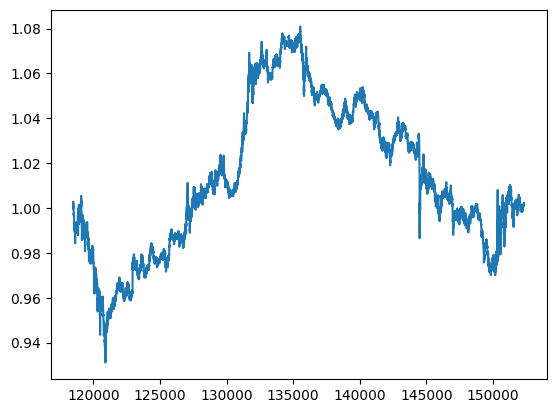

In [31]:
(1 + df_test[df_test["currency_pair"] == "ADAUSDT"]["return_pips_adjusted"] / 1e4).cumprod().plot()

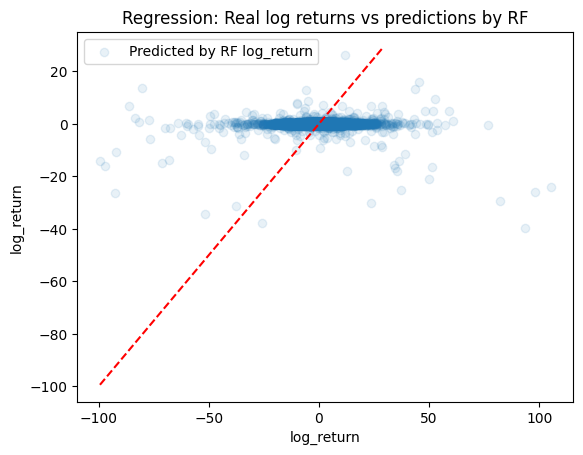

In [15]:
y_pred: np.ndarray = model_rf_base.predict(df_test[reg_features.regressors])

plt.scatter(df_test[target_col], y_pred, label="Predicted by RF log_return", alpha=.1)
x_min, x_max = df_test[target_col].min(), df_val[target_col].max()

X = np.linspace(x_min, x_max, 1000)
plt.plot(X, X, linestyle="--", color="red")

plt.title("Regression: Real log returns vs predictions by RF")
plt.xlabel("log_return")
plt.ylabel("log_return")
plt.legend()

plt.savefig("rf_predictions.png")
plt.show()

In [16]:
from sklearn.metrics import r2_score, classification_report, accuracy_score

r2_score(y_pred=y_pred, y_true=df_test[reg_features.target])

-0.0077391447437515914

In [18]:
y_pred_binary: np.ndarray = (y_pred >= 0).astype(int)
y_true_binary: np.ndarray = (df_test[reg_features.target] >= 0).astype(int)

print(
    classification_report(y_pred=y_pred_binary, y_true=y_true_binary)
)

              precision    recall  f1-score   support

           0       0.48      0.56      0.52     43434
           1       0.62      0.55      0.59     58122

    accuracy                           0.55    101556
   macro avg       0.55      0.55      0.55    101556
weighted avg       0.56      0.55      0.56    101556



In [19]:
accuracy_score(y_pred=y_pred_binary, y_true=y_true_binary)

0.553586198747489

In [20]:
pd.DataFrame({
    "name": model_rf_base.feature_names_in_,
    "fi": model_rf_base.feature_importances_
}).sort_values(by="fi", ascending=False)

,name,fi
24,log_return_60.0S,0.088223
25,log_return_120.0S,0.081113
20,log_return_2.0S,0.065668
19,log_return_1.0S,0.065517
23,log_return_30.0S,0.065477
18,log_return_0.5S,0.059149
22,log_return_10.0S,0.058273
26,log_return_300.0S,0.053190
21,log_return_5.0S,0.051990
11,slippage_imbalance_2.0S,0.020540
